## Install Pytorch if needed

In [0]:
# http://pytorch.org/


# from os.path import exists
# from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
# platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
# cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
# accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

# !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
# import torch

## Import modules

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np

print("Pytorch version:  " + str(torch.__version__))
use_cuda = torch.cuda.is_available()
print("Use CUDA: " + str(use_cuda))

from torch.autograd import Variable
from torch.utils.data import DataLoader
import torch.optim.lr_scheduler as lr_scheduler
from torch.autograd.function import Function
import math

from pdb import set_trace as bp

BATCH_SIZE = 100
FEATURES_DIM = 3
NUM_OF_CLASSES = 10
BATCH_SIZE_TEST = 1000
EPOCHS = 20
LOG_INTERVAL = 10

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        krnl_sz=3
        strd = 1
                    
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=20, kernel_size=krnl_sz, stride=strd, padding=1)
        self.conv2 = nn.Conv2d(in_channels=20, out_channels=50, kernel_size=krnl_sz, stride=strd, padding=1)
        self.prelu1_1 = nn.PReLU()
        self.prelu1_2 = nn.PReLU()
        
        self.conv3 = nn.Conv2d(in_channels=50, out_channels=64, kernel_size=krnl_sz, stride=strd, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=krnl_sz, stride=strd, padding=1)
        self.prelu2_1 = nn.PReLU()
        self.prelu2_2 = nn.PReLU()

        self.conv5 = nn.Conv2d(in_channels=128, out_channels=512, kernel_size=krnl_sz, stride=strd, padding=1)
        self.conv6 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=krnl_sz, stride=strd, padding=1)
        self.prelu3_1 = nn.PReLU()
        self.prelu3_2 = nn.PReLU()

        self.prelu_weight = nn.Parameter(torch.Tensor(1).fill_(0.25))

        self.fc1 = nn.Linear(3*3*512, 3)
        self.fc3 = nn.Linear(3, 10)

    def forward(self, x):
        mp_ks=2
        mp_strd=2

        x = self.prelu1_1(self.conv1(x))
        x = self.prelu1_2(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=mp_ks, stride=mp_strd)

        x = self.prelu2_1(self.conv3(x))
        x = self.prelu2_2(self.conv4(x))
        x = F.max_pool2d(x, kernel_size=mp_ks, stride=mp_strd)

        x = self.prelu3_1(self.conv5(x))
        x = self.prelu3_2(self.conv6(x))
        x = F.max_pool2d(x, kernel_size=mp_ks, stride=mp_strd)

        x = x.view(-1, 3*3*512) # Flatten
        features3d = F.prelu(self.fc1(x), self.prelu_weight)
        x = self.fc3(features3d)
    
        return features3d, x
        
class Arcface_loss(nn.Module):
    def __init__(self, num_classes, feat_dim, device, s=7.0, m=0.2):
        super(Arcface_loss, self).__init__()
        self.feat_dim = feat_dim
        self.num_classes = num_classes
        self.s = s
        self.m = m
        self.weights = nn.Parameter(torch.randn(num_classes, feat_dim))
        self.device = device

        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.mm = math.sin(math.pi-m)*m
        self.threshold = math.cos(math.pi-m)

    def forward(self, feat, label):
        eps = 1e-4
        batch_size = feat.shape[0]
        norms = torch.norm(feat, p=2, dim=-1, keepdim=True)
        feat_l2norm = torch.div(feat, norms)
        feat_l2norm = feat_l2norm * self.s

        norms_w = torch.norm(self.weights, p=2, dim=-1, keepdim=True)
        weights_l2norm = torch.div(self.weights, norms_w)

        fc7 = torch.matmul(feat_l2norm, torch.transpose(weights_l2norm, 0, 1))

        if torch.cuda.is_available():
            label = label.cuda()
            fc7 = fc7.cuda()
        else:
            label = label.cpu()
            fc7 = fc7.cpu()

        target_one_hot = torch.zeros(len(label), NUM_OF_CLASSES).to(self.device)
        target_one_hot = target_one_hot.scatter_(1, label.unsqueeze(1), 1.)        
        zy = torch.addcmul(torch.zeros(fc7.size()).to(self.device), 1., fc7, target_one_hot)
        zy = zy.sum(-1)

        cos_theta = zy/self.s
        cos_theta = cos_theta.clamp(min=-1+eps, max=1-eps) # for numerical stability

        theta = torch.acos(cos_theta)
        theta = theta+self.m

        body = torch.cos(theta)
        new_zy = body*self.s

        diff = new_zy - zy
        diff = diff.unsqueeze(1)

        body = torch.addcmul(torch.zeros(diff.size()).to(self.device), 1., diff, target_one_hot)
        output = fc7+body

        return output.to(self.device)
  

def train(model, device, train_loader, loss_softmax, loss_arcface, optimizer_nn, optimzer_arcface, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        features, _ = model(data)
        logits = loss_arcface(features, target)
        loss = loss_softmax(logits, target)

        _, predicted = torch.max(logits.data, 1)
        accuracy = (target.data == predicted).float().mean()

        optimizer_nn.zero_grad()
        optimzer_arcface.zero_grad()

        loss.backward()

        optimizer_nn.step()
        optimzer_arcface.step()

        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def test(model, device, test_loader, loss_softmax, loss_arcface):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)

            feats, _ = model(data)
            logits = loss_arcface(feats, target)
            _, predicted = torch.max(logits.data, 1)
            total += target.size(0)
            correct += (predicted == target.data).sum()

    print('\nTest set:, Accuracy: {}/{} ({:.0f}%)\n'.format(
        correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))    

###################################################################

torch.manual_seed(1)
device = torch.device("cuda" if use_cuda else "cpu")

####### Data setup

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=BATCH_SIZE, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=BATCH_SIZE_TEST, shuffle=True, **kwargs)

####### Model setup

model = Net().to(device)
loss_softmax = nn.CrossEntropyLoss().to(device)
loss_arcface = Arcface_loss(num_classes=10, feat_dim=FEATURES_DIM, device=device).to(device)

# optimzer nn
optimizer_nn = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)
sheduler_nn = lr_scheduler.StepLR(optimizer_nn, 20, gamma=0.1)

# optimzer cosface or arcface
optimzer_arcface = optim.SGD(loss_arcface.parameters(), lr=0.01)
sheduler_arcface = lr_scheduler.StepLR(optimzer_arcface, 20, gamma=0.1)


for epoch in range(1, EPOCHS + 1):
    sheduler_nn.step()
    sheduler_arcface.step()

    train(model, device, train_loader, loss_softmax, loss_arcface, optimizer_nn, optimzer_arcface, epoch)
    test(model, device, test_loader, loss_softmax, loss_arcface)

torch.save(model.state_dict(),"mnist_cnn-arcface.pt")        
torch.save(loss_arcface.state_dict(),"mnist_loss-arcface.pt")        


Pytorch version:  0.4.1
Use CUDA: True
Train Epoch: 1 [0/60000 (0%)]	Loss: 8.759495
Train Epoch: 1 [1000/60000 (2%)]	Loss: 5.584503
Train Epoch: 1 [2000/60000 (3%)]	Loss: 5.084148
Train Epoch: 1 [3000/60000 (5%)]	Loss: 5.421575
Train Epoch: 1 [4000/60000 (7%)]	Loss: 4.729795
Train Epoch: 1 [5000/60000 (8%)]	Loss: 4.445458
Train Epoch: 1 [6000/60000 (10%)]	Loss: 4.056414
Train Epoch: 1 [7000/60000 (12%)]	Loss: 4.490729
Train Epoch: 1 [8000/60000 (13%)]	Loss: 4.192997
Train Epoch: 1 [9000/60000 (15%)]	Loss: 4.706395
Train Epoch: 1 [10000/60000 (17%)]	Loss: 4.100759
Train Epoch: 1 [11000/60000 (18%)]	Loss: 4.184603
Train Epoch: 1 [12000/60000 (20%)]	Loss: 3.943612
Train Epoch: 1 [13000/60000 (22%)]	Loss: 3.787384
Train Epoch: 1 [14000/60000 (23%)]	Loss: 3.765548
Train Epoch: 1 [15000/60000 (25%)]	Loss: 3.666354
Train Epoch: 1 [16000/60000 (27%)]	Loss: 3.583413
Train Epoch: 1 [17000/60000 (28%)]	Loss: 3.406068
Train Epoch: 1 [18000/60000 (30%)]	Loss: 3.421217
Train Epoch: 1 [19000/60000 (3

## Train process

In [0]:
# model = Net().to(device)
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

# for epoch in range(1, EPOCHS + 1):
#     train(model, device, train_loader, optimizer, epoch)
#     test(model, device, test_loader)

# torch.save(model.state_dict(),"mnist_cnn-arcface.pt")


In [0]:
# # Download from COLAB
# from google.colab import files
# files.download('mnist_cnn-arcface.pt') 
# files.download('mnist_loss-arcface.pt') 


## Load Model

In [3]:
device = torch.device("cuda" if use_cuda else "cpu")
model = Net()
model.eval()
model.load_state_dict(torch.load("mnist_cnn-arcface.pt", map_location=device))
model.to(device)

Net(
  (conv1): Conv2d(1, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (prelu1_1): PReLU(num_parameters=1)
  (prelu1_2): PReLU(num_parameters=1)
  (conv3): Conv2d(50, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (prelu2_1): PReLU(num_parameters=1)
  (prelu2_2): PReLU(num_parameters=1)
  (conv5): Conv2d(128, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (prelu3_1): PReLU(num_parameters=1)
  (prelu3_2): PReLU(num_parameters=1)
  (fc1): Linear(in_features=4608, out_features=3, bias=True)
  (fc3): Linear(in_features=3, out_features=10, bias=True)
)

In [0]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

PREDICTION : 7


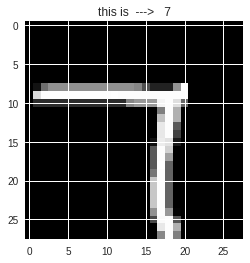

In [5]:
ind = 141

image = test_loader.dataset[ind][0].numpy().reshape(28,28)
lbl = test_loader.dataset[ind][1].numpy()
plt.title('this is  --->   ' + str(lbl))
plt.imshow(image, cmap='gray')


image_tensor, label_tensor = test_loader.dataset[ind]
image_tensor = image_tensor.reshape(1,1,28,28)
image_tensor, label_tensor = image_tensor.to(device), label_tensor.to(device)

arcface_loss = Arcface_loss(num_classes=10, feat_dim=FEATURES_DIM, device=device)
arcface_loss.eval()
arcface_loss.load_state_dict(torch.load("mnist_loss-arcface.pt", map_location=device))
arcface_loss.to(device)

features3d, pr = model(image_tensor)
logits = arcface_loss(features3d, torch.unsqueeze(label_tensor, dim=-1))
_, prediction = torch.max(logits.data, 1)
prediction = prediction.cpu().detach().numpy()[0]

print ("PREDICTION : " + str(prediction) )

-----------

In [0]:
# Visualize train_data

In [7]:
f3d = []
# f2d = []
lbls = []
for i in range(10000):
    image_tensor, label_tensor = test_loader.dataset[i]
    image_tensor = image_tensor.reshape(1,1,28,28)
    image_tensor, label_tensor = image_tensor.to(device), label_tensor.to(device)

    features3d, pr  = model(image_tensor)
    logits = arcface_loss(features3d, torch.unsqueeze(label_tensor, dim=-1))
    _, prediction = torch.max(logits.data, 1)

    f3d.append(features3d[0].cpu().detach().numpy())
#     f2d.append(features2d[0].cpu().detach().numpy())
    
    prediction = prediction.cpu().detach().numpy()[0]
    lbls.append(prediction)

#     print("features3d:  " + str(features3d[0].detach().numpy()))
#     print("features2d:  " + str(features2d[0].detach().numpy()))

# feat3d = np.array(f3d)
# print("3d features shape" + str(feat3d.shape))

feat3d = np.array(f3d)
print("3d features shape" + str(feat3d.shape))

lbls = np.array(lbls)
print("labels shape" + str(lbls.shape))


3d features shape(10000, 3)
labels shape(10000,)


# Visualize 2d

In [0]:
# import matplotlib.pyplot as plt
# %matplotlib inline

# f = plt.figure(figsize=(16,9))
# c = ['#ff0000', '#ffff00', '#00ff00', '#00ffff', '#0000ff', 
#      '#ff00ff', '#990000', '#999900', '#009900', '#009999']
# for i in range(10):
#     plt.plot(feat2d[lbls==i,0].flatten(), feat2d[lbls==i,1].flatten(), '.', c=c[i])
# plt.legend(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])

# plt.grid()
# plt.show()

# Visualize 3d

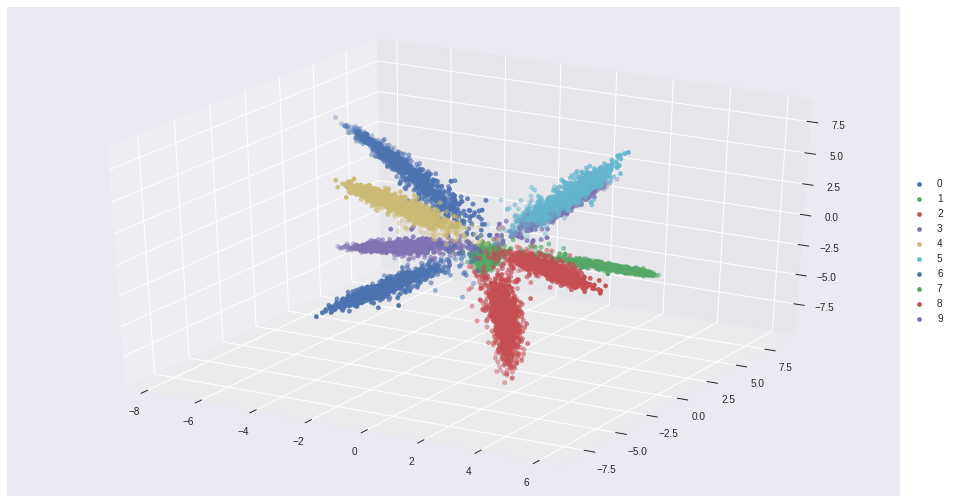

In [9]:
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(16,9))
ax = plt.axes(projection='3d')

for i in range(10):
    # Data for three-dimensional scattered points
    xdata = feat3d[lbls==i,2].flatten()
    ydata = feat3d[lbls==i,0].flatten()
    zdata = feat3d[lbls==i,1].flatten()
    ax.scatter3D(xdata, ydata, zdata);
ax.legend(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'],loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()